# This notebook calculates and creates a Mean Annual DMC plot

*Currently this notebook relies on using both netCDF4 and xarray packages. This should not be necessary, and isn't helpful as the two can have conflicting conda dependencies*
*Additionally, there is a requirement of the regionmask package, rather than specifying the regions by hand. This is sensible and flexible. However, this can cuase issues and may fail on the import step relating to the libpoppler library. Specifying an older version of this library, via poppler<0.62 is a suggested workaround.*

In [1]:
#import packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy
from sklearn.metrics import mean_squared_error
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF
import matplotlib
import matplotlib.collections as collections
import regionmask
from matplotlib import gridspec 

In [2]:
#define pmip generations and model names
pmip_v4='PMIP4'
pmip_v3='PMIP3'
pmip={}
#Define pimp generations and model names
pmip_v4='PMIP4'
pmip_v3='PMIP3'
pmip={}
pmip['PMIP4']=['AWI-ESM-1-1-LR',
               'CESM2',
               'EC-Earth3-LR',
               'FGOALS-f3-L',
               'FGOALS-g3',
               'GISS-E2-1-G',
               'HadGEM3-GC31',
               'INM-CM4-8',
               'IPSL-CM6A-LR',
               'MIROC-ES2L',
               'MPI-ESM1-2-LR',
               'MRI-ESM2-0',
               'NESM3',
               'NorESM1-F',
               'NorESM2-LM',
               'UofT-CCSM-4']
pmip['PMIP3']=['BCC-CSM1-1',
               'CCSM4',
               'CNRM-CM5',
               'CSIRO-Mk3L-1-2',
               'CSIRO-Mk3-6-0',
               'EC-EARTH-2-2',
               'FGOALS-g2',
               'FGOALS-s2',
               'GISS-E2-R',
               'HadGEM2-CC',
               'HadGEM2-ES',
               'IPSL-CM5A-LR',
               'MIROC-ESM',
               'MPI-ESM-P',
               'MRI-CGCM3']
               
               
  




# recons data from Bartlein et al., 2010

In [3]:
# define a longitude latitude grid
lon_2 = np.arange(-179, 180,2)
lat_2 = np.arange(-89, 90,2)

srex_mask = regionmask.defined_regions.srex.mask(lon_2, lat_2, xarray=False)

# region numbers
#NEU 11
#CEU 12
#MED 13
#SAH 14
#EAS 22
#ENA 5

#Define SREX regions and their corresponding number used in plotting

SREXmask={'NEU':[11],'CEU':[12],'MED':[13],'SAH':[14],'EAS':[22],'ENA':[5]}
regions=['NEU','CEU','MED','SAH','EAS','ENA']

#SREXmask={'TIB':[21],'CAS':[20]}
#regions=['TIB','CAS']

#masking example:
#c=ma.masked_where(mask!=14, testdata)

In [4]:
#Reconstruction data over land (source: Bartlein et al., 2010)
recons_filename='../recons/bartlein/map_delta_06ka_ALL_grid_2x2.nc'
d=Dataset(recons_filename)
map_recons=d.variables['map_anm_mean'][:]
d.close()

In [25]:
recons_data=[]
for region in regions:
    re=[]
    region=region
    c=ma.masked_where(srex_mask!=SREXmask[region][0], map_recons)
    xnan=np.ma.filled(c.astype(float), np.nan)
    for row in range(90):
        for col in range(180):
            val=str(xnan[row][col])
            if val != 'nan':
                re.append(val)
    a=np.array(re).astype(float)
    recons_data.append(a)

In [26]:
# Add B17 data to recons list
b17_map=map_recons[65:75,105:150]
rr=np.ma.filled(b17_map, np.nan)
re=[]
for row in range(rr.shape[0]):
    for col in range(rr.shape[1]):
        val=str(rr[row][col])
        if val != 'nan':
            val1=float(val)
            re.append(val1) 
a=np.array(re).astype(float)
recons_data.append(re)

In [27]:
recons_data

[array([ 3.60476646e+01,  3.05150223e+00,  4.10676689e+01,  1.31767242e+02,
        -7.08100653e+00,  1.10675995e+02, -8.98816776e+00,  2.76747398e+01,
        -1.18465042e+01,  6.59932556e+01, -1.42975044e+01,  3.00966702e+01,
         1.32300949e+00,  3.55403709e+01,  2.72914963e+01,  6.02882500e+01,
         1.05744247e+02,  8.94112015e+01, -7.12999964e+00,  1.01733505e+02,
        -2.68125038e+01,  8.27993240e+01,  1.90649979e+02,  8.35625000e+01,
         6.13004990e+01,  6.20340004e+01,  4.27429962e+01, -7.34104919e+01,
        -2.08010101e+01,  4.16145020e+01,  1.85104004e+02, -3.09635986e+02,
         1.19100189e+00,  8.72321777e+01,  1.64583603e+02,  6.15302505e+01,
         2.04815006e+01,  1.18679001e+02,  1.12873550e+02,  1.28560822e+02,
         1.10400002e+02,  7.26316071e+01, -2.23840008e+01,  1.46511246e+02,
        -1.66687256e+02,  1.78184967e+01,  5.24336662e+01,  1.35388245e+02,
        -3.53330040e+01, -6.14750061e+01,  8.71646652e+01,  2.10990860e+02,
         8.9

# PMIP mean annual precipitation changes

In [28]:
# MH paper
def modelregionave(pmip):
    modellist=pd.read_csv('%s_modellist.csv'%pmip,skipinitialspace=True,header=0)['model']
    fn='../outputs/netcdf/%s_mh_diff_pr_ann_2deg.nc'%pmip
    dset=Dataset(fn)
    DATA={}
    for model in modellist:
        D=[]
        data=dset[model]
        for region in regions:
            c=ma.masked_where(srex_mask!=SREXmask[region][0], data)
            ave=np.average(c)*365
            D.append(ave)
        dd=data[65:75,105:150]      
        ave=np.average(dd)*365
        D.append(ave)
        DATA[model]=D
    DA=pd.DataFrame(DATA)
    return modellist,DA

In [20]:
# IPCC figure
def modelregionave(pmip):
    modellist=pd.read_csv('%s_modellist.csv'%pmip,skipinitialspace=True,header=0)['model']
    fn='../outputs/netcdf/%s_mh_diff_pr_ann_2deg.nc'%pmip
    dset=Dataset(fn)
    DATA={}
    for model in modellist:
        D=[]
        data=dset[model]
        for region in regions:
            c=ma.masked_where(srex_mask!=SREXmask[region][0], data)
            ave=np.average(c)*365
            D.append(ave)
        DATA[model]=D
    DA=pd.DataFrame(DATA)
    return modellist,DA

In [29]:
model_list3,d3=modelregionave('PMIP3')
model_list4,d4=modelregionave('PMIP4')

In [12]:
pd.DataFrame(d3)

,BCC-CSM1-1,CCSM4,CNRM-CM5,CSIRO-Mk3-6-0,CSIRO-Mk3L-1-2,EC-EARTH-2-2,FGOALS-s2,FGOALS-g2,GISS-E2-R,HadGEM2-CC,HadGEM2-ES,IPSL-CM5A-LR,MIROC-ESM,MPI-ESM-P,MRI-CGCM3
0,-0.107708,-25.550887,38.709141,21.554267,4.888783,15.151778,3.880829,-29.537939,45.425031,24.177181,16.357261,13.414502,-0.814153,16.615700,9.999225
1,-11.602191,-22.387490,20.303967,-22.837198,-12.479469,-0.150203,2.124325,-40.164420,31.989213,-4.635320,-8.424211,11.799079,-12.649135,35.929173,5.879425
2,9.920176,16.895191,20.130787,-16.975440,3.683078,23.828355,9.317259,13.476647,58.501120,30.092067,20.828810,14.914988,17.113966,12.995548,3.294042
3,15.895699,59.765947,58.455771,-12.987650,17.636531,94.701963,58.887776,57.921269,29.041342,15.722782,15.056566,14.999409,56.108338,44.399779,3.459217
4,-22.986822,-18.698175,-7.861172,79.981847,40.304446,-4.596703,-30.459826,-48.643427,42.447485,5.965954,1.313615,9.345061,-17.771643,19.706042,-9.501774
5,19.892299,-21.508021,-30.930060,-6.831847,19.272254,-12.752688,-25.876014,-55.382284,29.991377,-57.584899,-54.624417,14.497541,-40.965235,-22.533167,-8.764331
6,1.513202,-3.979963,5.517532,-8.002866,3.350786,-13.458816,5.362633,-18.993008,4.193043,9.448065,8.192843,-3.893633,-36.749579,-4.331057,3.797031


In [13]:
pd.DataFrame(d4)

,AWI-ESM-1-1-LR,CESM2,EC-Earth3-LR,FGOALS-f3-L,FGOALS-g3,GISS-E2-1-G,HadGEM3-GC31,INM-CM4-8,IPSL-CM6A-LR,MIROC-ES2L,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM1-F,NorESM2-LM,UofT-CCSM-4
0,-9.062439,-2.819458,64.724403,-7.777045,-60.760633,1.767279,19.410491,-9.279973,-17.582487,-3.803905,-3.406614,10.326140,26.665319,-20.643642,229.474352,-9.596742
1,0.207375,-34.633810,8.092439,-4.148538,-92.526843,8.180007,-0.631554,7.104121,-24.578278,-1.339656,-8.838412,5.437834,13.415231,-1.921485,92.624973,-14.032143
2,27.936170,10.993807,25.942064,22.626872,-20.246960,24.144568,-2.119325,56.844078,30.111605,11.932887,28.128816,39.156496,22.553221,14.366567,21.478437,26.928018
3,102.305447,26.633834,21.315808,26.127332,-3.919926,26.377934,16.946357,70.703759,47.522727,34.179270,65.447722,28.831795,74.627111,43.858053,26.844733,64.401247
4,-30.161636,-36.394526,-14.569915,-20.354205,-57.307495,-4.473202,6.332284,-20.614591,-4.561320,-61.892691,-3.401857,-18.969428,17.188010,-31.084274,26.148603,-7.477899
5,-87.007755,-68.245726,-9.964467,-24.875902,-68.475674,-0.490071,-45.300081,-12.317580,-38.173894,-14.898167,-43.164808,-21.629943,57.889444,-32.488271,36.635283,-14.142948
6,-16.017072,-13.590951,9.194389,-9.075170,-44.727724,-9.253882,1.442391,-0.018029,-24.842121,-23.963947,-16.436513,-21.064146,12.624549,-3.917903,126.098099,-2.733486


# Plotting

In [30]:
#Generate plotting positions 
p1=[0.3,1.3,2.3,3.3,4.3,5.3,6.3]
p2=[0.5,1.5,2.5,3.5,4.5,5.5,6.5]
p3=[0.7,1.7,2.7,3.7,4.7,5.7,6.7]
#Generate ref. lines
xlines=[1,2,3,4,5,6]
ylines=[-500,0,500]

In [31]:
recons=np.array(recons_data)

# old version

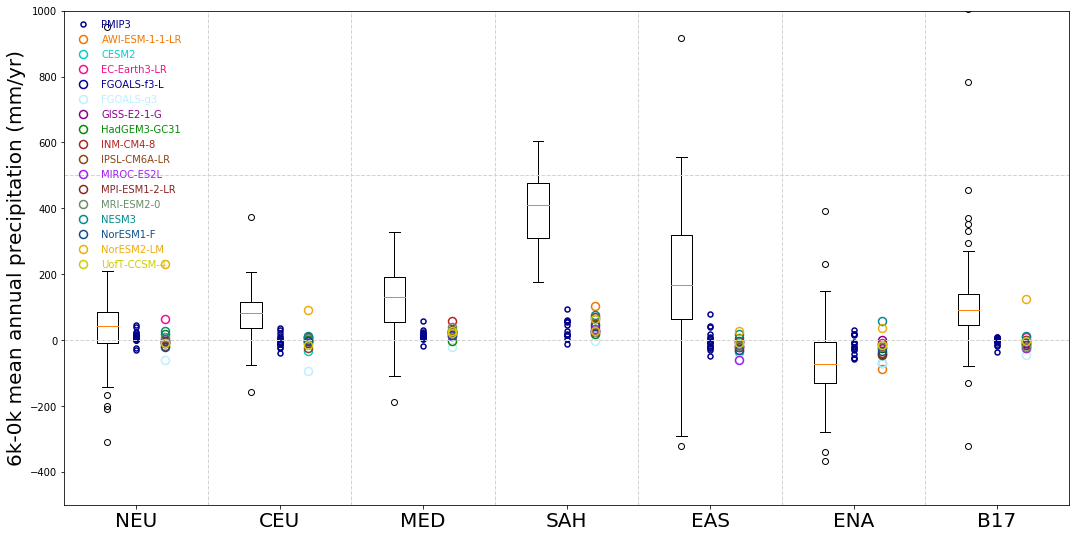

In [14]:
region_name=['NEU','CEU','MED','SAH','EAS','ENA','B17']
color_r=pd.read_csv('PMIP4_modellist.csv',skipinitialspace=True,header=0)['r']
color_g=pd.read_csv('PMIP4_modellist.csv',skipinitialspace=True,header=0)['g']
color_b=pd.read_csv('PMIP4_modellist.csv',skipinitialspace=True,header=0)['b']


plt.figure(figsize=(18,20))
plt.subplot(211)
plt.ylim((-500,1000))
plt.xlim((0,7))
plt.boxplot(recons_data,positions=p1,widths=0.15)
for i in range(len(model_list3)):
    plt.plot(p2,d3[model_list3[i]],marker='o', color='darkblue',fillstyle='none',mew=1.5, ms=5,linestyle='None')
plt.plot(p2,d3[model_list3[0]],marker='o', color='darkblue',fillstyle='none',mew=1.5, ms=5,linestyle='None',label='PMIP3')
for i in range(len(model_list4)):
    plt.plot(p3,d4[model_list4[i]],marker='o',color=(color_r[i],color_g[i],color_b[i]),fillstyle='none',mew=1.5, ms=8,linestyle='None',label=model_list4[i])
plt.xticks(p2,region_name,fontsize=20)

#plt.xticks(p2[6],'Mid-continental Eurasia',fontsize=20)
leg=plt.legend(edgecolor='None',facecolor='None')
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
for xi in xlines:
    plt.axvline(xi,color='lightgrey',linestyle="--",linewidth=1)
for yi in ylines:
    plt.axhline(yi,color='lightgrey',linestyle="--",linewidth=1)
plt.ylabel('6k-0k mean annual precipitation (mm/yr)',fontsize=20) 



# new version

Text(7.3, 750, 'Reconstructions')

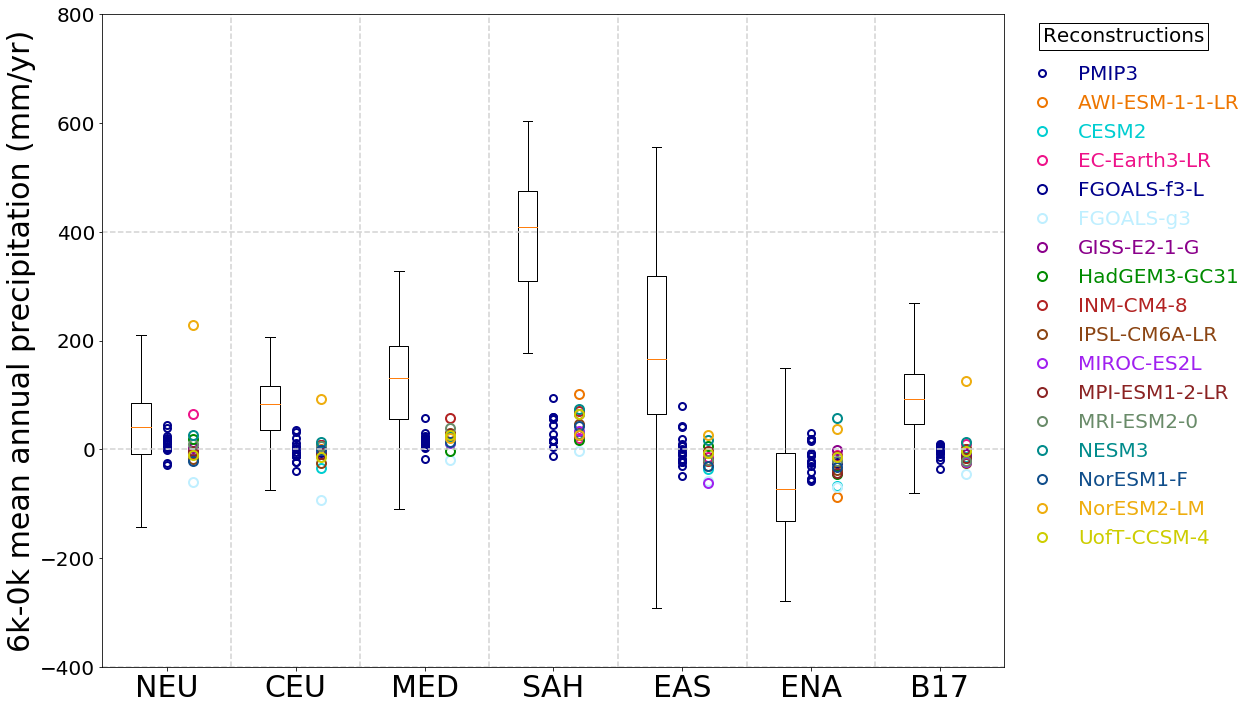

In [33]:
region_name=['NEU','CEU','MED','SAH','EAS','ENA','B17']
color_r=pd.read_csv('PMIP4_modellist.csv',skipinitialspace=True,header=0)['r']
color_g=pd.read_csv('PMIP4_modellist.csv',skipinitialspace=True,header=0)['g']
color_b=pd.read_csv('PMIP4_modellist.csv',skipinitialspace=True,header=0)['b']
ylines=[-400,0,400]

plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(1, 2, width_ratios=[8, 1]) 
plt.subplot(gs[0]) 
plt.ylim((-400,800))
plt.xlim((0,7))
plt.boxplot(recons_data,positions=p1,widths=0.15,showfliers =False)
for i in range(len(model_list3)):
    plt.plot(p2,d3[model_list3[i]],marker='o', color='darkblue',fillstyle='none',mew=2, ms=7,linestyle='None')
plt.plot(p2,d3[model_list3[0]],marker='o', color='darkblue',fillstyle='none',mew=2, ms=7,linestyle='None',label='PMIP3')
for i in range(len(model_list4)):
    plt.plot(p3,d4[model_list4[i]],marker='o',color=(color_r[i],color_g[i],color_b[i]),fillstyle='none',mew=2, ms=9,linestyle='None',label=model_list4[i])
plt.xticks(p2,region_name,fontsize=30)

#plt.xticks(p2[6],'Mid-continental Eurasia',fontsize=20)
leg=plt.legend(bbox_to_anchor=(1,0.95), loc='upper left',edgecolor='None',facecolor='None', borderaxespad=0.5,fontsize=20)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
for xi in xlines:
    plt.axvline(xi,color='lightgrey',linestyle="--",linewidth=1.5)
for yi in ylines:
    plt.axhline(yi,color='lightgrey',linestyle="--",linewidth=1.5)
plt.ylabel('6k-0k mean annual precipitation (mm/yr)',fontsize=30) 
plt.yticks(fontsize=20)
plt.text(7.3, 750, 'Reconstructions',bbox=dict(ec='black',fc='white'),color='black', weight='roman',fontsize=20)



# IPCC fig

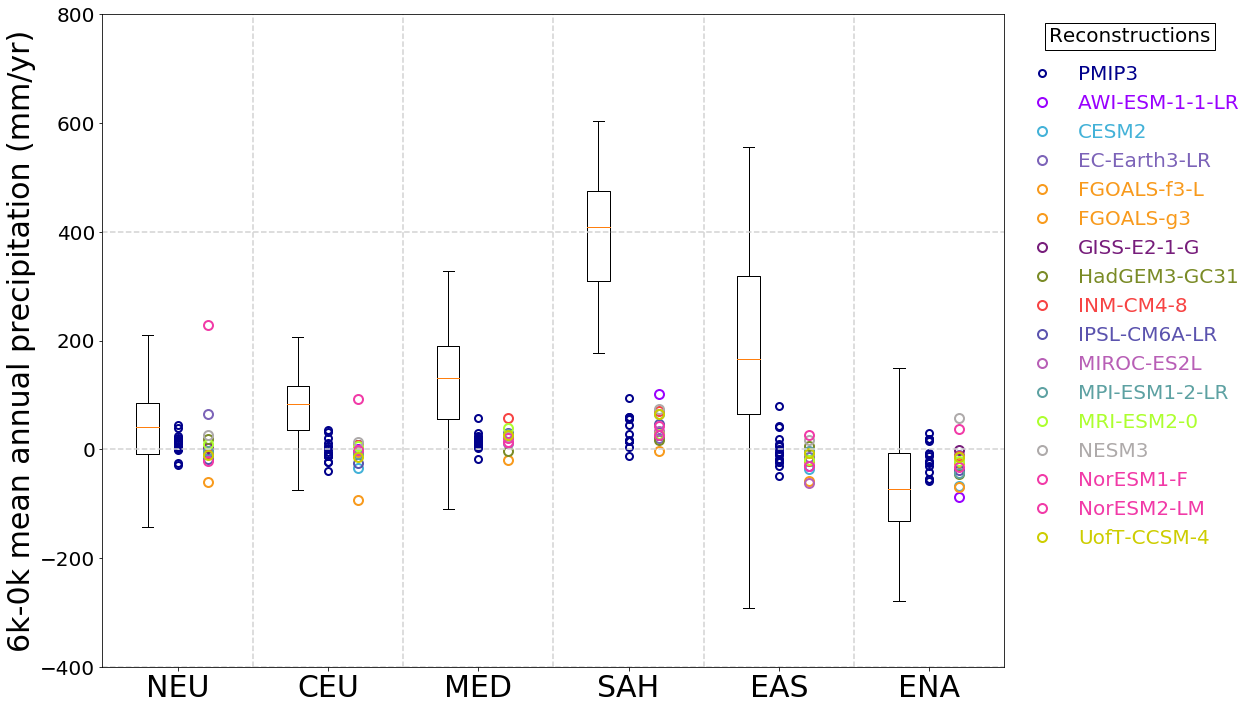

In [24]:
region_name=['NEU','CEU','MED','SAH','EAS','ENA']
color_r=pd.read_csv('PMIP4_modellist.csv',skipinitialspace=True,header=0)['ipccr']
color_g=pd.read_csv('PMIP4_modellist.csv',skipinitialspace=True,header=0)['ipccg']
color_b=pd.read_csv('PMIP4_modellist.csv',skipinitialspace=True,header=0)['ipccb']
ylines=[-400,0,400]

plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(1, 2, width_ratios=[8, 1]) 
plt.subplot(gs[0]) 
plt.ylim((-400,800))
plt.xlim((0,6))
plt.boxplot(recons_data,positions=p1,widths=0.15,showfliers =False)
for i in range(len(model_list3)):
    plt.plot(p2,d3[model_list3[i]],marker='o', color='darkblue',fillstyle='none',mew=2, ms=7,linestyle='None')
plt.plot(p2,d3[model_list3[0]],marker='o', color='darkblue',fillstyle='none',mew=2, ms=7,linestyle='None',label='PMIP3')
for i in range(len(model_list4)):
    plt.plot(p3,d4[model_list4[i]],marker='o',color=(color_r[i],color_g[i],color_b[i]),fillstyle='none',mew=2, ms=9,linestyle='None',label=model_list4[i])
plt.xticks(p2,region_name,fontsize=30)

#plt.xticks(p2[6],'Mid-continental Eurasia',fontsize=20)
leg=plt.legend(bbox_to_anchor=(1,0.95), loc='upper left',edgecolor='None',facecolor='None', borderaxespad=0.5,fontsize=20)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
for xi in xlines:
    plt.axvline(xi,color='lightgrey',linestyle="--",linewidth=1.5)
for yi in ylines:
    plt.axhline(yi,color='lightgrey',linestyle="--",linewidth=1.5)
plt.ylabel('6k-0k mean annual precipitation (mm/yr)',fontsize=30) 
plt.yticks(fontsize=20)
plt.text(6.3, 750, 'Reconstructions',bbox=dict(ec='black',fc='white'),color='black', weight='roman',fontsize=20)

